<a href="https://colab.research.google.com/github/Emily-KD/DS200/blob/main/chpt_17_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade datascience

     |████████████████████████████████| 731 kB 12.9 MB/s 
     |████████████████████████████████| 95 kB 3.2 MB/s 
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
  Attempting uninstall: datascience
    Found existing installation: datascience 0.10.6
    Uninstalling datascience-0.10.6:
      Successfully uninstalled datascience-0.10.6


In [ ]:
import matplotlib
#matplotlib.use('Agg')
path_data = 'http://personal.psu.edu/drh20/200DS/assets/data/'
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import scipy.stats as stats
plots.style.use('fivethirtyeight')

#chpt 17 Classification

*[David Wagner](https://people.eecs.berkeley.edu/~daw/) is the primary author of this chapter.*

*Machine learning* is a class of techniques for automatically finding patterns in data and using it to draw inferences or make predictions.  You have already seen linear regression, which is one kind of machine learning.  This chapter introduces a new one: *classification*.

Classification is about learning how to make predictions from past examples.  We are given some examples where we have been told what the correct prediction was, and we want to learn from those examples how to make good predictions in the future.  Here are a few applications where classification is used in practice:

- For each order Amazon receives, Amazon would like to predict: ***is this order fraudulent?***  They have some information about each order (e.g., its total value, whether the order is being shipped to an address this customer has used before, whether the shipping address is the same as the credit card holder's billing address).  They have lots of data on past orders, and they know which of those past orders were fraudulent and which weren't.  They want to learn patterns that will help them predict, as new orders arrive, whether those new orders are fraudulent.

- Online dating sites would like to predict: ***are these two people compatible?***  Will they hit it off?  They have lots of data on which matches they've suggested to their customers in the past, and they have some idea which ones were successful.  As new customers sign up, they'd like to make predictions about who might be a good match for them.

- Doctors would like to know: ***does this patient have cancer?***  Based on the measurements from some lab test, they'd like to be able to predict whether the particular patient has cancer.  They have lots of data on past patients, including their lab measurements and whether they ultimately developed cancer, and from that, they'd like to try to infer what measurements tend to be characteristic of cancer (or non-cancer) so they can diagnose future patients accurately.

- Politicians would like to predict: ***are you going to vote for them?***  This will help them focus fundraising efforts on people who are likely to support them, and focus get-out-the-vote efforts on voters who will vote for them.  Public databases and commercial databases have a lot of information about most people: e.g., whether they own a home or rent; whether they live in a rich neighborhood or poor neighborhood; their interests and hobbies; their shopping habits; and so on.  And political campaigns have surveyed some voters and found out who they plan to vote for, so they have some examples where the correct answer is known.  From this data, the campaigns would like to find patterns that will help them make predictions about all other potential voters.

All of these are classification tasks.  Notice that in each of these examples, the prediction is a yes/no question -- we call this *binary classification*, because there are only two possible predictions.

In a classification task, each individual or situation where we'd like to make a prediction is called an *observation*.  We ordinarily have many observations.  Each observation has multiple *attributes*, which are known (for example, the total value of the order on Amazon, or the voter's annual salary).  Also, each observation has a *class*, which is the answer to the question we care about (for example, fraudulent or not, or voting for you or not).

When Amazon is predicting whether orders are fraudulent, each order corresponds to a single observation.  Each observation has several attributes: the total value of the order, whether the order is being shipped to an address this customer has used before, and so on.  The class of the observation is either 0 or 1, where 0 means that the order is not fraudulent and 1 means that the order is fraudulent.  When a customer makes a new order, we do not observe whether it is fraudulent, but we do observe its attributes, and we will try to predict its class using those attributes.

Classification requires data.  It involves looking for patterns, and to find patterns, you need data.  That's where the data science comes in.  In particular, we're going to assume that we have access to *training data*: a bunch of observations, where we know the class of each observation.  The collection of these pre-classified observations is also called a training set.  A classification algorithm is going to analyze the training set, and then come up with a classifier: an algorithm for predicting the class of future observations.

Classifiers do not need to be perfect to be useful.  They can be useful even if their accuracy is less than 100%.  For instance, if the online dating site occasionally makes a bad recommendation, that's OK; their customers already expect to have to meet many people before they'll find someone they hit it off with.  Of course, you don't want the classifier to make too many errors &mdash; but it doesn't have to get the right answer every single time.

##17.1. Nearest Neighbors
In this section we'll develop the *nearest neighbor* method of classification. Just focus on the ideas for now and don't worry if some of the code is mysterious. Later in the chapter we'll see how to organize our ideas into code that performs the classification.

In [ ]:
def standard_units(x):
    return (x - np.mean(x))/np.std(x)

In [ ]:
def distance(point1, point2):
    """The distance between two arrays of numbers."""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, point):
    """The distance between p (an array of numbers) and the numbers in row i of attribute_table."""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(point, np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, point):
    """A copy of the training table with the distance from each row to array p."""
    return training.with_column('Distance', all_distances(training, point))

def closest(training, point, k):
    """A table containing the k closest rows in the training table to array p."""
    with_dists = table_with_distances(training, point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    """1 if the majority of the "Class" column is 1s, and 0 otherwise."""
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, p, k):
    """Classify an example with attributes p using k-nearest neighbor classification with the given training table."""
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

###17.1.1. Chronic kidney disease

Let's work through an example.  We're going to work with a data set that was collected to help doctors diagnose chronic kidney disease (CKD).  Each row in the data set represents a single patient who was treated in the past and whose diagnosis is known.  For each patient, we have a bunch of measurements from a blood test.  We'd like to find which measurements are most useful for diagnosing CKD, and develop a way to classify future patients as "has CKD" or "doesn't have CKD" based on their blood test results.

In [ ]:
ckd = Table.read_table(path_data + 'ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1
68,80,1.01,3,2,normal,abnormal,present,present,157,90,4.1,130,6.4,5.6,16,11000,2.6,yes,yes,yes,poor,yes,no,1
61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,148,3.9,135,5.2,7.7,24,9200,3.2,yes,yes,yes,poor,yes,yes,1
48,80,1.025,4,0,normal,abnormal,notpresent,notpresent,95,163,7.7,136,3.8,9.8,32,6900,3.4,yes,no,no,good,no,yes,1
69,70,1.01,3,4,normal,abnormal,notpresent,notpresent,264,87,2.7,130,4,12.5,37,9600,4.1,yes,yes,yes,good,yes,no,1
73,70,1.005,0,0,normal,normal,notpresent,notpresent,70,32,0.9,125,4,10,29,18900,3.5,yes,yes,no,good,yes,no,1
73,80,1.02,2,0,abnormal,abnormal,notpresent,notpresent,253,142,4.6,138,5.8,10.5,33,7200,4.3,yes,yes,yes,good,no,no,1
46,60,1.01,1,0,normal,normal,notpresent,notpresent,163,92,3.3,141,4,9.8,28,14600,3.2,yes,yes,no,good,no,no,1


Some of the variables are categorical (words like "abnormal"), and some quantitative. The quantitative variables all have different scales. We're going to want to make comparisons and estimate distances, often by eye, so let's select just a few of the variables and work in standard units. Then we won't have to worry about the scale of each of the different variables.

In [ ]:
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'White Blood Cell Count', standard_units(ckd.column('White Blood Cell Count')),
    'Class', ckd.column('Class')
)

In [ ]:
ckd

Hemoglobin,Glucose,White Blood Cell Count,Class
-0.865744,-0.221549,-0.569768,1
-1.45745,-0.947597,1.16268,1
-1.00497,3.84123,-1.27558,1
-2.81488,0.396364,0.809777,1
-2.08395,0.643529,0.232293,1
-1.35303,-0.561402,-0.505603,1
-0.413266,2.04928,0.360623,1
-1.28342,-0.947597,3.34429,1
-1.10939,1.87936,-0.409356,1
-1.35303,0.489051,1.96475,1


Let's look at two columns in particular: the hemoglobin level (in the patient's blood), and the blood glucose level (at a random time in the day; without fasting specially for the blood test). 

We'll draw a scatter plot to visualize the relation between the two variables. Blue dots are patients with CKD; gold dots are patients without CKD.  What kind of medical test results seem to indicate CKD?

In [ ]:
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)

In [ ]:
ckd

Class,Hemoglobin,Glucose,White Blood Cell Count,Color
0,0.456884,0.133751,0.617283,gold
0,1.153,-0.947597,0.424788,gold
0,0.770138,-0.762223,0.200211,gold
0,0.596108,-0.190654,-0.73018,gold
0,-0.239236,-0.49961,-0.0564489,gold
0,-0.0304002,-0.159758,0.232293,gold
0,0.282854,-0.00527964,0.71353,gold
0,0.108824,-0.623193,0.200211,gold
0,0.0740178,-0.515058,-0.0243664,gold
0,0.83975,-0.422371,-1.33975,gold


Suppose Alice is a new patient who is not in the data set.  If I tell you Alice's hemoglobin level and blood glucose level, could you predict whether she has CKD?  It sure looks like it!  You can see a very clear pattern here: points in the lower-right tend to represent people who don't have CKD, and the rest tend to be folks with CKD.  To a human, the pattern is obvious.  But how can we program a computer to automatically detect patterns such as this one?

###17.1.2. A Nearest Neighbor Classifier

There are lots of kinds of patterns one might look for, and lots of algorithms for classification.  But I'm going to tell you about one that turns out to be surprisingly effective.  It is called *nearest neighbor classification*.  Here's the idea.  If we have Alice's hemoglobin and glucose numbers, we can put her somewhere on this scatterplot; the hemoglobin is her x-coordinate, and the glucose is her y-coordinate.  Now, to predict whether she has CKD or not, we find the nearest point in the scatterplot and check whether it is blue or gold; we predict that Alice should receive the same diagnosis as that patient.

In other words, to classify Alice as CKD or not, we find the patient in the training set who is "nearest" to Alice, and then use that patient's diagnosis as our prediction for Alice.  The intuition is that if two points are near each other in the scatterplot, then the corresponding measurements are pretty similar, so we might expect them to receive the same diagnosis (more likely than not).  We don't know Alice's diagnosis, but we do know the diagnosis of all the patients in the training set, so we find the patient in the training set who is most similar to Alice, and use that patient's diagnosis to predict Alice's diagnosis.

In the graph below, the red dot represents Alice. It is joined with a black line to the point that is nearest to it – its *nearest neighbor* in the training set. The figure is drawn by a function called `show_closest`. It takes an array that represents the $x$ and $y$ coordinates of Alice's point. Vary those to see how the closest point changes! Note especially when the closest point is blue and when it is gold.

In [ ]:
def show_closest(point):
    """point = array([x,y]) 
    gives the coordinates of a new point
    shown in red"""
    
    HemoGl = ckd.drop('White Blood Cell Count', 'Color')
    t = closest(HemoGl, point, 1)
    x_closest = t.row(0).item(1)
    y_closest = t.row(0).item(2)
    ckd.scatter('Hemoglobin', 'Glucose', group='Color')
    plots.scatter(point.item(0), point.item(1), color='red', s=30)
    plots.plot(make_array(point.item(0), x_closest), make_array(point.item(1), y_closest), color='k', lw=2);

In [ ]:
ckd.drop('White Blood Cell Count', 'Color')

Class,Hemoglobin,Glucose
0,0.456884,0.133751
0,1.153,-0.947597
0,0.770138,-0.762223
0,0.596108,-0.190654
0,-0.239236,-0.49961
0,-0.0304002,-0.159758
0,0.282854,-0.00527964
0,0.108824,-0.623193
0,0.0740178,-0.515058
0,0.83975,-0.422371


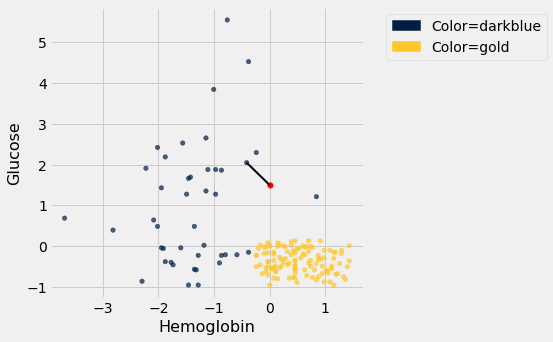

In [ ]:
# In this example, Alice's Hemoglobin attribute is 0 and her Glucose is 1.5.
alice = make_array(0, 1.5)
show_closest(alice)

Thus our *nearest neighbor classifier* works like this:
- Find the point in the training set that is nearest to the new point.
- If that nearest point is a "CKD" point, classify the new point as "CKD". If the nearest point is a "not CKD" point, classify the new point as "not CKD".

The scatterplot suggests that this nearest neighbor classifier should be pretty accurate.  Points in the lower-right will tend to receive a "no CKD" diagnosis, as their nearest neighbor will be a gold point.  The rest of the points will tend to receive a "CKD" diagnosis, as their nearest neighbor will be a blue point.  So the nearest neighbor strategy seems to capture our intuition pretty well, for this example.

###17.1.3. Decision boundary

Sometimes a helpful way to visualize a classifier is to map out the kinds of attributes where the classifier would predict 'CKD', and the kinds where it would predict 'not CKD'.  We end up with some boundary between the two, where points on one side of the boundary will be classified 'CKD' and points on the other side will be classified 'not CKD'.  This boundary is called the *decision boundary*.  Each different classifier will have a different decision boundary; the decision boundary is just a way to visualize what criteria the classifier is using to classify points.

For example, suppose the coordinates of Alice's point are (0, 1.5). Notice that the nearest neighbor is blue. Now try reducing the height (the $y$-coordinate) of the point. You'll see that at around $y = 0.95$ the nearest neighbor turns from blue to gold.

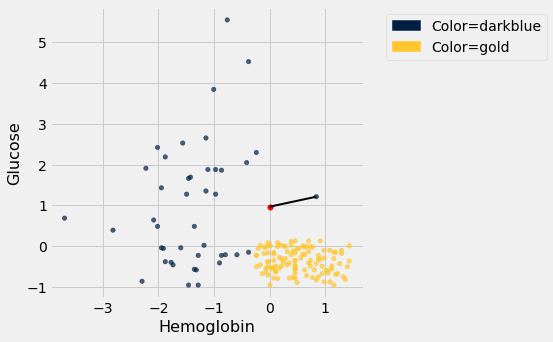

In [ ]:
alice = make_array(0, 0.97)
show_closest(alice)

Here are hundreds of new unclassified points, all in red.

In [ ]:
x_array = make_array()
y_array = make_array()
for x in np.arange(-2, 2.1, 0.1):
    for y in np.arange(-2, 2.1, 0.1):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)
        
test_grid = Table().with_columns(
    'Hemoglobin', x_array,
    'Glucose', y_array
)

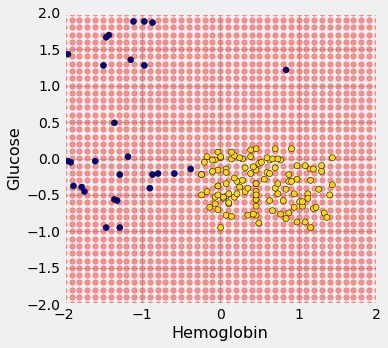

In [ ]:
test_grid.scatter('Hemoglobin', 'Glucose', color='red', alpha=0.4, s=30)

plots.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Color'), edgecolor='k')

plots.xlim(-2, 2)
plots.ylim(-2, 2);

Each of the red points has a nearest neighbor in the training set (the same blue and gold points as before). For some red points you can easily tell whether the nearest neighbor is blue or gold. For others, it's a little more tricky to make the decision by eye. Those are the points near the decision boundary.

But the computer can easily determine the nearest neighbor of each point. So let's get it to apply our nearest neighbor classifier to each of the red points: 

For each red point, it must find the closest point in the training set; it must then change the color of the red point to become the color of the nearest neighbor. 

The resulting graph shows which points will get classified as 'CKD' (all the blue ones), and which as 'not CKD' (all the gold ones).

In [ ]:
def classify_grid(training, test, k):
    c = make_array()
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = np.append(c, classify(training, make_array(test.row(i)), k))   
    return c

In [ ]:
c = classify_grid(ckd.drop('White Blood Cell Count', 'Color'), test_grid, 1)

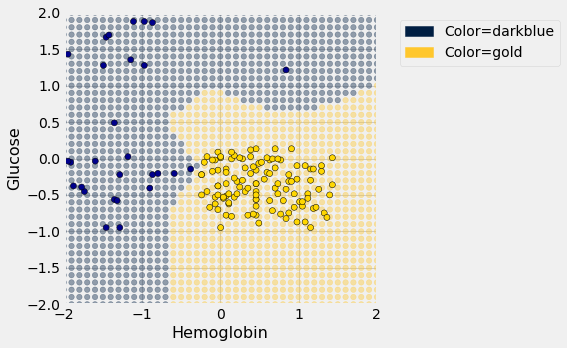

In [ ]:
test_grid = test_grid.with_column('Class', c).join('Class', color_table)
test_grid.scatter('Hemoglobin', 'Glucose', group='Color', alpha=0.4, s=30)

plots.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Color'), edgecolor='k')

plots.xlim(-2, 2)
plots.ylim(-2, 2);

The decision boundary is where the classifier switches from turning the red points blue to turning them gold.

###17.1.4. k-Nearest Neighbors

However, the separation between the two classes won't always be quite so clean.  For instance, suppose that instead of hemoglobin levels we were to look at white blood cell count.  Look at what happens:

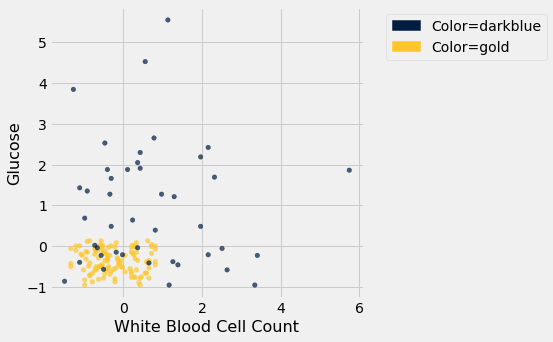

In [ ]:
ckd.scatter('White Blood Cell Count', 'Glucose', group='Color')

As you can see, non-CKD individuals are all clustered in the lower-left.  Most of the patients with CKD are above or to the right of that cluster... but not all.  There are some patients with CKD who are in the lower left of the above figure (as indicated by the handful of blue dots scattered among the gold cluster).  What this means is that you can't tell for certain whether someone has CKD from just these two blood test measurements.

If we are given Alice's glucose level and white blood cell count, can we predict whether she has CKD?  Yes, we can make a prediction, but we shouldn't expect it to be 100% accurate.  Intuitively, it seems like there's a natural strategy for predicting: plot where Alice lands in the scatter plot; if she is in the lower-left, predict that she doesn't have CKD, otherwise predict she has CKD.  

This isn't perfect -- our predictions will sometimes be wrong.  (Take a minute and think it through: for which patients will it make a mistake?)  As the scatterplot above indicates, sometimes people with CKD have glucose and white blood cell levels that look identical to those of someone without CKD, so any classifier is inevitably going to make the wrong prediction for them.

Can we automate this on a computer?  Well, the nearest neighbor classifier would be a reasonable choice here too.  Take a minute and think it through: how will its predictions compare to those from the intuitive strategy above?  When will they differ?

Its predictions will be pretty similar to our intuitive strategy, but occasionally it will make a different prediction.  In particular, if Alice's blood test results happen to put her right near one of the blue dots in the lower-left, the intuitive strategy would predict 'not CKD', whereas the nearest neighbor classifier will predict 'CKD'.

There is a simple generalization of the nearest neighbor classifier that fixes this anomaly.  It is called the *k-nearest neighbor classifier*.  To predict Alice's diagnosis, rather than looking at just the one neighbor closest to her, we can look at the 3 points that are closest to her, and use the diagnosis for each of those 3 points to predict Alice's diagnosis.  In particular, we'll use the majority value among those 3 diagnoses as our prediction for Alice's diagnosis.  Of course, there's nothing special about the number 3: we could use 4, or 5, or more.  (It's often convenient to pick an odd number, so that we don't have to deal with ties.)  In general, we pick a number $k$, and our predicted diagnosis for Alice is based on the $k$ patients in the training set who are closest to Alice.  Intuitively, these are the $k$ patients whose blood test results were most similar to Alice, so it seems reasonable to use their diagnoses to predict Alice's diagnosis.

The $k$-nearest neighbor classifier will now behave just like our intuitive strategy above.

##17.2. Training and Testing
How good is our nearest neighbor classifier? To answer this we'll need to find out how frequently our classifications are correct. If a patient has chronic kidney disease, how likely is our classifier to pick that up?

If the patient is in our training set, we can find out immediately. We already know what class the patient is in. So we can just compare our prediction and the patient's true class.

But the point of the classifier is to make predictions for *new* patients not in our training set. We don't know what class these patients are in but we can make a prediction based on our classifier. How to find out whether the prediction is correct?

One way is to wait for further medical tests on the patient and then check whether or not our prediction agrees with the test results. With that approach, by the time we can say how likely our prediction is to be accurate, it is no longer useful for helping the patient.

Instead, we will try our classifier on some patients whose true classes are known.  Then, we will compute the proportion of the time our classifier was correct.  This proportion will serve as an estimate of the proportion of all new patients whose class our classifier will accurately predict.  This is called *testing*.

In [ ]:
def standard_units(x):
    return (x - np.mean(x))/np.std(x)

In [ ]:
def distance(pt1, pt2):
    return np.sqrt(np.sum((pt1 - pt2)**2))

def all_dists(training, p):
    attributes = training.drop('Class')
    def dist_point_row(row):
        return distance(np.array(row), p)
    return attributes.apply(dist_point_row)

def table_with_distances(training, p):
    return training.with_column('Distance', all_dists(training, p))

def closest(training, p, k):
    with_dists = table_with_distances(training, p)
    sorted_by_dist = with_dists.sort('Distance')
    topk = sorted_by_dist.take(np.arange(k))
    return topk

def majority(topkclasses):
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, p, k):
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

In [ ]:
def classify_grid(training, test, k):
    c = make_array()
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = np.append(c, classify(training, make_array(test.row(i)), k))   
    return c

In [ ]:
ckd = Table.read_table(path_data + 'ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'White Blood Cell Count', standard_units(ckd.column('White Blood Cell Count')),
    'Class', ckd.column('Class')
)
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)

###17.2.1. Overly Optimistic "Testing"
The training set offers a very tempting set of patients on whom to test out our classifier, because we know the class of each patient in the training set.

But let's be careful ... there will be pitfalls ahead if we take this path. An example will show us why.

Suppose we use a 1-nearest neighbor classifier to predict whether a patient has chronic kidney disease, based on glucose and white blood cell count.

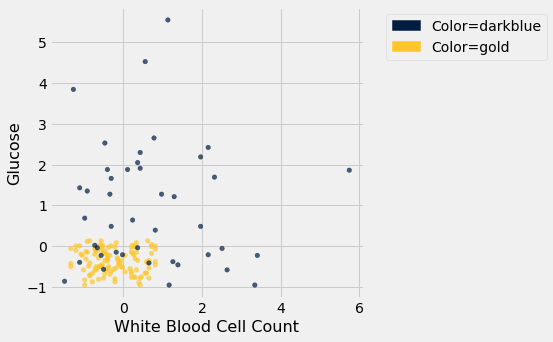

In [ ]:
ckd.scatter('White Blood Cell Count', 'Glucose', group='Color')

Earlier, we said that we expect to get some classifications wrong, because there's some intermingling of blue and gold points in the lower-left.

But what about the points in the training set, that is, the points already on the scatter? Will we ever mis-classify them?

The answer is no. Remember that 1-nearest neighbor classification looks for the point *in the training set* that is nearest to the point being classified. Well, if the point being classified is already in the training set, then its nearest neighbor in the training set is itself! And therefore it will be classified as its own color, which will be correct because each point in the training set is already correctly colored.

In other words, **if we use our training set to "test" our 1-nearest neighbor classifier, the classifier will pass the test 100% of the time.**

Mission accomplished. What a great classifier! 

No, not so much. A new point in the lower-left might easily be mis-classified, as we noted earlier. "100% accuracy" was a nice dream while it lasted.

The lesson of this example is *not* to use the training set to test a classifier that is based on it.

###17.2.2. Generating a Test Set
In earlier chapters, we saw that random sampling could be used to estimate the proportion of individuals in a population that met some criterion.  Unfortunately, we have just seen that the training set is not like a random sample from the population of all patients, in one important respect: Our classifier guesses correctly for a higher proportion of individuals in the training set than it does for individuals in the population.

When we computed confidence intervals for numerical parameters, we wanted to have many new random samples from a population, but we only had access to a single sample.  We solved that problem by taking bootstrap resamples from our sample.

We will use an analogous idea to test our classifier. We will *create two samples out of the original training set*, use one of the samples as our training set, and *the other one for testing*. 

So we will have three groups of individuals:
- a training set on which we can do any amount of exploration to build our classifier;
- a separate testing set on which to try out our classifier and see what fraction of times it classifies correctly;
- the underlying population of individuals for whom we don't know the true classes; the hope is that our classifier will succeed about as well for these individuals as it did for our testing set.

How to generate the training and testing sets? You've guessed it – we'll select at random.

There are 158 individuals in `ckd`. Let's use a random half of them for training and the other half for testing. To do this, we'll shuffle all the rows, take the first 79 as the training set, and the remaining 79 for testing.

In [ ]:
shuffled_ckd = ckd.sample(with_replacement=False)
training = shuffled_ckd.take(np.arange(79))
testing = shuffled_ckd.take(np.arange(79, 158))

Now let's construct our classifier based on the points in the training sample:

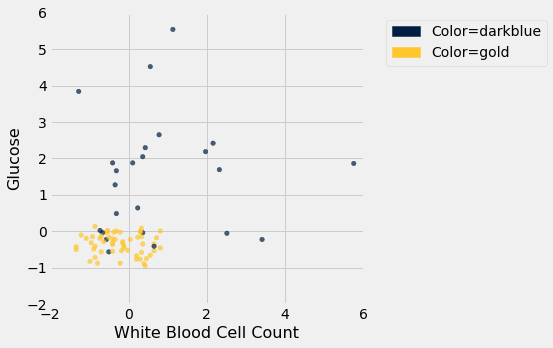

In [ ]:
training.scatter('White Blood Cell Count', 'Glucose', group='Color')
plots.xlim(-2, 6)
plots.ylim(-2, 6);

We get the following classification regions and decision boundary:

In [ ]:
x_array = make_array()
y_array = make_array()
for x in np.arange(-2, 6.1, 0.25):
    for y in np.arange(-2, 6.1, 0.25):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)
        
test_grid = Table().with_columns(
    'Glucose', x_array,
    'White Blood Cell Count', y_array
)

In [ ]:
c = classify_grid(training.drop('Hemoglobin', 'Color'), test_grid, 1)

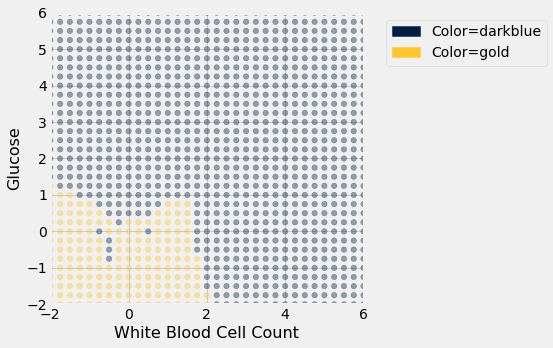

In [ ]:
test_grid = test_grid.with_column('Class', c).join('Class', color_table)
test_grid.scatter('White Blood Cell Count', 'Glucose', group='Color', alpha=0.4, s=30)

plots.xlim(-2, 6)
plots.ylim(-2, 6);

Place the *test* data on this graph and you can see at once that while the classifier got almost all the points right, there are some mistakes.  For example, some blue points of the test set fall in the gold region of the classifier.

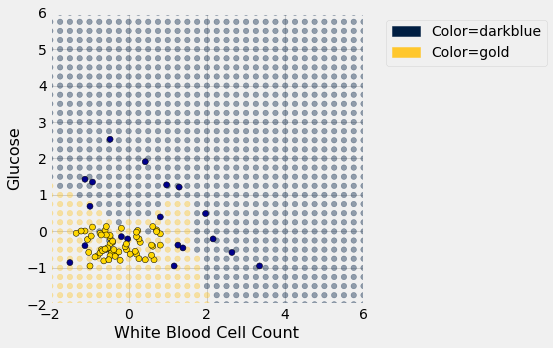

In [ ]:
test_grid = test_grid.with_column('Class', c).join('Class', color_table)
test_grid.scatter('White Blood Cell Count', 'Glucose', group='Color', alpha=0.4, s=30)

plots.scatter(testing.column('White Blood Cell Count'), testing.column('Glucose'), c=testing.column('Color'), edgecolor='k')

plots.xlim(-2, 6)
plots.ylim(-2, 6);

Some errors notwithstanding, it looks like the classifier does fairly well on the test set. Assuming that the original sample was drawn randomly from the underlying population, the hope is that the classifier will perform with similar accuracy on the overall population, since the test set was chosen randomly from the original sample.

##17.3. Rows of Tables
Now that we have a qualitative understanding of nearest neighbor classification, it's time to implement our classifier.

Until this chapter, we have worked mostly with single columns of tables. But now we have to see whether one *individual* is "close" to another. Data for individuals are contained in *rows* of tables.

So let's start by taking a closer look at rows.

In [ ]:
def standard_units(x):
    return (x - np.mean(x))/np.std(x)

Here is the original table `ckd` containing data on patients who were tested for chronic kidney disease.

In [ ]:
ckd = Table.read_table(path_data + 'ckd.csv').relabeled('Blood Glucose Random', 'Glucose')

In [ ]:
ckd

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1
68,80,1.01,3,2,normal,abnormal,present,present,157,90,4.1,130,6.4,5.6,16,11000,2.6,yes,yes,yes,poor,yes,no,1
61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,148,3.9,135,5.2,7.7,24,9200,3.2,yes,yes,yes,poor,yes,yes,1
48,80,1.025,4,0,normal,abnormal,notpresent,notpresent,95,163,7.7,136,3.8,9.8,32,6900,3.4,yes,no,no,good,no,yes,1
69,70,1.01,3,4,normal,abnormal,notpresent,notpresent,264,87,2.7,130,4,12.5,37,9600,4.1,yes,yes,yes,good,yes,no,1
73,70,1.005,0,0,normal,normal,notpresent,notpresent,70,32,0.9,125,4,10,29,18900,3.5,yes,yes,no,good,yes,no,1
73,80,1.02,2,0,abnormal,abnormal,notpresent,notpresent,253,142,4.6,138,5.8,10.5,33,7200,4.3,yes,yes,yes,good,no,no,1
46,60,1.01,1,0,normal,normal,notpresent,notpresent,163,92,3.3,141,4,9.8,28,14600,3.2,yes,yes,no,good,no,no,1


The data corresponding to the first patient is in row 0 of the table, consistent with Python's indexing system. The Table method `row` accesses the row by taking the index of the row as its argument:

In [ ]:
ckd.row(0)

Row(Age=48, Blood Pressure=70, Specific Gravity=1.005, Albumin=4, Sugar=0, Red Blood Cells='normal', Pus Cell='abnormal', Pus Cell clumps='present', Bacteria='notpresent', Glucose=117, Blood Urea=56, Serum Creatinine=3.8, Sodium=111, Potassium=2.5, Hemoglobin=11.2, Packed Cell Volume=32, White Blood Cell Count=6700, Red Blood Cell Count=3.9, Hypertension='yes', Diabetes Mellitus='no', Coronary Artery Disease='no', Appetite='poor', Pedal Edema='yes', Anemia='yes', Class=1)

Rows have their very own data type: they are *row objects*. Notice how the display shows not only the values in the row but also the labels of the corresponding columns.

Rows are in general **not arrays**, as their elements can be of different types. For example, some of the elements of the row above are strings (like `'abnormal'`) and some are numerical. So the row can't be converted into an array.

However, rows share some characteristics with arrays.  You can use `item` to access a particular element of a row. For example, to access the Albumin level of Patient 0, we can look at the labels in the printout of the row above to find that it's item 3:

In [ ]:
ckd.row(0).item(3)

4

###17.3.1. Converting Rows to Arrays (When Possible)
Rows whose elements are all numerical (or all strings) can be converted to arrays.  Converting a row to an array gives us access to arithmetic operations and other nice NumPy functions, so it is often useful.

Recall that in the previous section we tried to classify the patients as 'CKD' or 'not CKD', based on two attributes `Hemoglobin` and `Glucose`, both measured in standard units. 

In [ ]:
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'Class', ckd.column('Class')
)

color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)
ckd

Class,Hemoglobin,Glucose,Color
0,0.456884,0.133751,gold
0,1.153,-0.947597,gold
0,0.770138,-0.762223,gold
0,0.596108,-0.190654,gold
0,-0.239236,-0.49961,gold
0,-0.0304002,-0.159758,gold
0,0.282854,-0.00527964,gold
0,0.108824,-0.623193,gold
0,0.0740178,-0.515058,gold
0,0.83975,-0.422371,gold


Here is a scatter plot of the two attributes, along with a red point corresponding to Alice, a new patient. Her value of hemoglobin is 0 (that is, at the average) and glucose 1.1 (that is, 1.1 SDs above average).

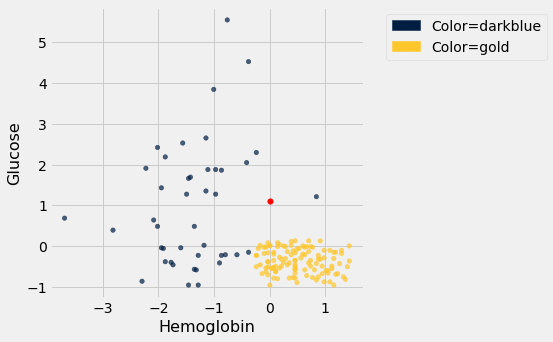

In [ ]:
alice = make_array(0, 1.1)
ckd.scatter('Hemoglobin', 'Glucose', group='Color')
plots.scatter(alice.item(0), alice.item(1), color='red', s=30);

To find the distance between Alice's point and any of the other points, we only need the values of the attributes:

In [ ]:
ckd_attributes = ckd.select('Hemoglobin', 'Glucose')

In [ ]:
ckd_attributes

Hemoglobin,Glucose
0.456884,0.133751
1.153,-0.947597
0.770138,-0.762223
0.596108,-0.190654
-0.239236,-0.49961
-0.0304002,-0.159758
0.282854,-0.00527964
0.108824,-0.623193
0.0740178,-0.515058
0.83975,-0.422371


Each row consists of the coordinates of one point in our training sample. **Because the rows now consist only of numerical values**, it is possible to convert them to arrays.  For this, we use the function `np.array`, which converts any kind of sequential object, like a row, to an array. (Our old friend `make_array` is for *creating* arrays, not for *converting* other kinds of sequences to arrays.)

In [ ]:
ckd_attributes.row(3)

Row(Hemoglobin=0.5961076648232668, Glucose=-0.19065363034327712)

In [ ]:
np.array(ckd_attributes.row(3))

array([ 0.59610766, -0.19065363])

In [ ]:
np.array(ckd.row(3))

array(['0', '0.5961076648232668', '-0.19065363034327712', 'gold'],
      dtype='<U32')

This is very handy because we can now use array operations on the data in each row.

###17.3.2. Distance Between Points When There are Two Attributes
The main calculation we need to do is to find the distance between Alice's point and any other point. For this, the first thing we need is a way to compute the distance between any pair of points. 

How do we do this?  In 2-dimensional space, it's pretty easy.  If we have a point at coordinates $(x_0,y_0)$ and another at $(x_1,y_1)$, the distance between them is

$$
D = \sqrt{(x_0-x_1)^2 + (y_0-y_1)^2}
$$

(Where did this come from?  It comes from the Pythogorean theorem: we have a right triangle with side lengths $x_0-x_1$ and $y_0-y_1$, and we want to find the length of the hypotenuse.)



In the next section we'll see that this formula has a straightforward extension when there are more than two attributes. For now, let's use the formula and array operations to find the distance between Alice and the patient in Row 3.

In [ ]:
patient3 = np.array(ckd_attributes.row(3))
alice, patient3

(array([0. , 1.1]), array([ 0.59610766, -0.19065363]))

In [ ]:
distance = np.sqrt(np.sum((alice - patient3)**2))
distance

1.421664918881847

We're going to need the distance between Alice and a bunch of points, so let's write a function called `distance` that computes the distance between any pair of points. The function will take two arrays, each containing the $(x, y)$ coordinates of a point.  (Remember, those are really the Hemoglobin and Glucose levels of a patient.)

In [ ]:
def distance(point1, point2):
    """Returns the Euclidean distance between point1 and point2.
    
    Each argument is an array containing the coordinates of a point."""
    return np.sqrt(np.sum((point1 - point2)**2))

In [ ]:
distance(alice, patient3)

1.421664918881847

We have begun to build our classifier: the `distance` function is the first building block. Now let's work on the next piece.

###17.3.3. Using `apply` on an Entire Row
Recall that if you want to apply a function to each element of a column of a table, one way to do that is by the call `table_name.apply(function_name, column_label)`. This evaluates to an array consisting of the values of the function when we call it on each element of the column. So each entry of the array is based on the corresponding row of the table.

If you use `apply` without specifying a column label, then the entire row is passed to the function. Let's see how this works on a very small table `t` containing the information about the first five patients in the training sample.

In [ ]:
t = ckd_attributes.take(np.arange(5))
t

Hemoglobin,Glucose
0.456884,0.133751
1.153,-0.947597
0.770138,-0.762223
0.596108,-0.190654
-0.239236,-0.49961


Just as an example, suppose that for each patient we want to know how unusual their most unusual attribute is.  Concretely, if a patient's hemoglobin level is further from the average than her glucose level, we want to know how far it is from the average.  If her glucose level is further from the average than her hemoglobin level, we want to know how far that is from the average instead.

That's the same as taking the maximum of the absolute values of the two quantities. To do this for a particular row, we can convert the row to an array and use array operations.

In [ ]:
def max_abs(row):
    return np.max(np.abs(np.array(row)))

In [ ]:
max_abs(t.row(4))

0.4996102825918697

And now we can apply `max_abs` to each row of the table `t`:

In [ ]:
t.apply(max_abs)

array([0.4568837 , 1.15300352, 0.77013762, 0.59610766, 0.49961028])

This way of using `apply` will help us create the next building block of our classifier.

###17.3.4. Alice's $k$ Nearest Neighbors
If we want to classify Alice using a k-nearest neighbor classifier, we have to identify her $k$ nearest neighbors. What are the steps in this process? Suppose $k = 5$. Then the steps are:
- **Step 1.** Find the distance between Alice and each point in the training sample.
- **Step 2.** Sort the data table in increasing order of the distances.
- **Step 3.** Take the top 5 rows of the sorted table.

Steps 2 and 3 seem straightforward, provided we have the distances. So let's focus on Step 1.

Here's Alice:

In [ ]:
alice

array([0. , 1.1])

What we need is a function that finds the distance between Alice and another point whose coordinates are contained in a row. The function `distance` returns the distance between any two points whose coordinates are in arrays. We can use that to define `distance_from_alice`, which takes a row as its argument and returns the distance between that row and Alice.

In [ ]:
def distance_from_alice(row):
    """Returns distance between Alice and a row of the attributes table"""
    return distance(alice, np.array(row))

In [ ]:
distance_from_alice(ckd_attributes.row(3))

1.421664918881847

Now we can `apply` the function `distance_from_alice` to each row of `ckd_attributes`, and augment the table `ckd` with the distances. Step 1 is complete!

In [ ]:
distances = ckd_attributes.apply(distance_from_alice)
ckd_with_distances = ckd.with_column('Distance from Alice', distances)

In [ ]:
ckd_with_distances

Class,Hemoglobin,Glucose,Color,Distance from Alice
0,0.456884,0.133751,gold,1.06882
0,1.153,-0.947597,gold,2.34991
0,0.770138,-0.762223,gold,2.01519
0,0.596108,-0.190654,gold,1.42166
0,-0.239236,-0.49961,gold,1.6174
0,-0.0304002,-0.159758,gold,1.26012
0,0.282854,-0.00527964,gold,1.1409
0,0.108824,-0.623193,gold,1.72663
0,0.0740178,-0.515058,gold,1.61675
0,0.83975,-0.422371,gold,1.73862


For Step 2, let's sort the table in increasing order of distance:

In [ ]:
sorted_by_distance = ckd_with_distances.sort('Distance from Alice')
sorted_by_distance

Class,Hemoglobin,Glucose,Color,Distance from Alice
1,0.83975,1.2151,darkblue,0.847601
1,-0.970162,1.27689,darkblue,0.986156
0,-0.0304002,0.0874074,gold,1.01305
0,0.14363,0.0874074,gold,1.02273
1,-0.413266,2.04928,darkblue,1.03534
0,0.387272,0.118303,gold,1.05532
0,0.456884,0.133751,gold,1.06882
0,0.178436,0.0410639,gold,1.07386
0,0.00440582,0.025616,gold,1.07439
0,-0.169624,0.025616,gold,1.08769


Step 3: The top 5 rows correspond to Alice's 5 nearest neighbors; you can replace 5 by any other positive integer.

In [ ]:
alice_5_nearest_neighbors = sorted_by_distance.take(np.arange(5))
alice_5_nearest_neighbors #Alice is dark blue because 3/5 it is dark blue

Class,Hemoglobin,Glucose,Color,Distance from Alice
1,0.83975,1.2151,darkblue,0.847601
1,-0.970162,1.27689,darkblue,0.986156
0,-0.0304002,0.0874074,gold,1.01305
0,0.14363,0.0874074,gold,1.02273
1,-0.413266,2.04928,darkblue,1.03534


Three of Alice's five nearest neighbors are blue points and two are gold. So a 5-nearest neighbor classifier would classify Alice as blue: it would predict that Alice has chronic kidney disease.

The graph below zooms in on Alice and her five nearest neighbors. The two gold ones just inside the circle directly below the red point. The classifier says Alice is more like the three blue ones around her.

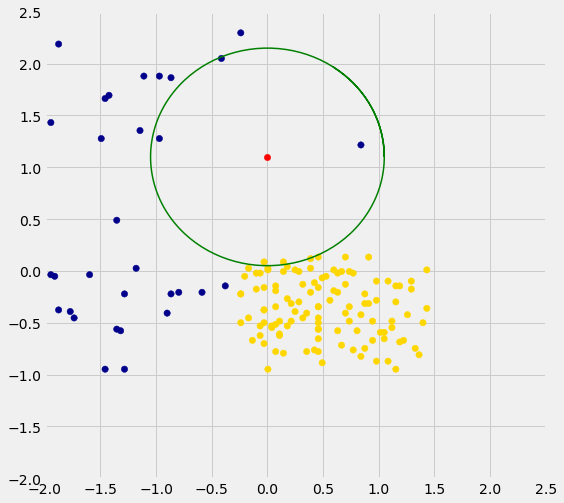

In [ ]:
plots.figure(figsize=(8,8))
plots.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Color'), s=40)
#ckd.scatter('Hemoglobin', 'Glucose', group='Color')
plots.scatter(alice.item(0), alice.item(1), color='red', s=40)
radius = sorted_by_distance.column('Distance from Alice').item(4)+0.014
theta = np.arange(0, 2*np.pi+1, 2*np.pi/200)
plots.plot(radius*np.cos(theta)+alice.item(0), radius*np.sin(theta)+alice.item(1), color='g', lw=1.5);
plots.xlim(-2, 2.5)
plots.ylim(-2, 2.5);

We are well on our way to implementing our k-nearest neighbor classifier. In the next two sections we will put it together and assess its accuracy.

##17.4. Implementing the Classifier
We are now ready to implement a $k$-nearest neighbor classifier based on multiple attributes. We have used only two attributes so far, for ease of visualization. But usually predictions will be based on many attributes. Here is an example that shows how multiple attributes can be better than pairs.

In [ ]:
import matplotlib
#matplotlib.use('Agg')
path_data = 'http://personal.psu.edu/drh20/200DS/assets/data/'
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import scipy.stats as stats
plt.style.use('fivethirtyeight')

###17.4.1. Banknote authentication

This time we'll look at predicting whether a banknote (e.g., a \$20 bill) is counterfeit or legitimate.  Researchers have put together a data set for us, based on photographs of many individual banknotes: some counterfeit, some legitimate.  They computed a few numbers from each image, using techniques that we won't worry about for this course.  So, for each banknote, we know a few numbers that were computed from a photograph of it as well as its class (whether it is counterfeit or not).  Let's load it into a table and take a look.

In [ ]:
banknotes = Table.read_table(path_data + 'banknote.csv')
banknotes

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0
3.4566,9.5228,-4.0112,-3.5944,0
0.32924,-4.4552,4.5718,-0.9888,0
4.3684,9.6718,-3.9606,-3.1625,0
3.5912,3.0129,0.72888,0.56421,0
2.0922,-6.81,8.4636,-0.60216,0
3.2032,5.7588,-0.75345,-0.61251,0
1.5356,9.1772,-2.2718,-0.73535,0


Let's look at whether the first two numbers tell us anything about whether the banknote is counterfeit or not.  Here's a scatterplot:

In [ ]:
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)

In [ ]:
banknotes = banknotes.join('Class', color_table)

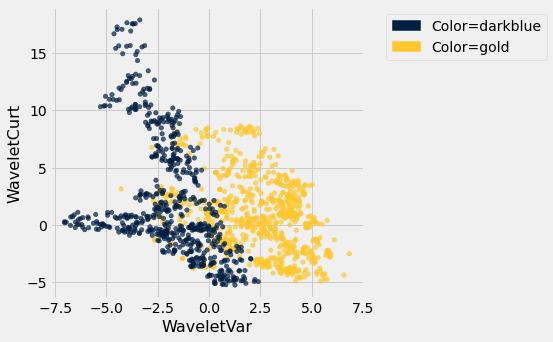

In [ ]:
banknotes.scatter('WaveletVar', 'WaveletCurt', group='Color')

Pretty interesting!  Those two measurements do seem helpful for predicting whether the banknote is counterfeit or not.  However, in this example you can now see that there is some overlap between the blue cluster and the gold cluster.  This indicates that there will be some images where it's hard to tell whether the banknote is legitimate based on just these two numbers.  Still, you could use a $k$-nearest neighbor classifier to predict the legitimacy of a banknote.

Take a minute and think it through: Suppose we used $k=11$ (say).  What parts of the plot would the classifier get right, and what parts would it make errors on?  What would the decision boundary look like?

The patterns that show up in the data can get pretty wild.  For instance, here's what we'd get if used a different pair of measurements from the images:

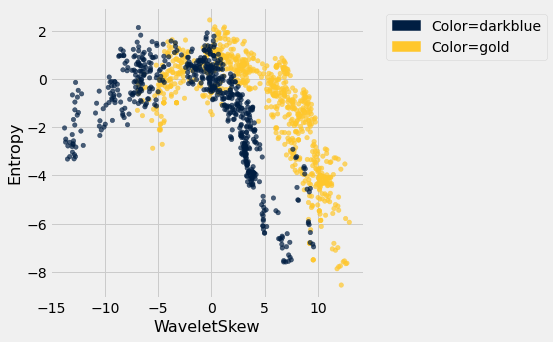

In [ ]:
banknotes.scatter('WaveletSkew', 'Entropy', group='Color')

There does seem to be a pattern, but it's a pretty complex one.  Nonetheless, the $k$-nearest neighbors classifier can still be used and will effectively "discover" patterns out of this.  This illustrates how powerful machine learning can be: it can effectively take advantage of even patterns that we would not have anticipated, or that we would have thought to "program into" the computer.

####Banknote authentication using pandas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plots
path_data = 'http://personal.psu.edu/drh20/200DS/assets/data/'

In [ ]:
banknotes = pd.read_csv(path_data + 'banknote.csv')
banknotes

,WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [ ]:
type(banknotes)

pandas.core.frame.DataFrame

In [ ]:
banknotes.groupby('Class').mean()

,WaveletVar,WaveletSkew,WaveletCurt,Entropy
Class,,,,
0,2.276686,4.256627,0.796718,-1.147640
1,-1.868443,-0.993576,2.148271,-1.246641


In [ ]:
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)

###17.4.2. Multiple attributes

So far I've been assuming that we have exactly 2 attributes that we can use to help us make our prediction.  What if we have more than 2?  For instance, what if we have 3 attributes?

Here's the cool part: you can use the same ideas for this case, too.  All you have to do is make a 3-dimensional scatterplot, instead of a 2-dimensional plot.  You can still use the $k$-nearest neighbors classifier, but now computing distances in 3 dimensions instead of just 2.  It just works.  Very cool!

In fact, there's nothing special about 2 or 3.  If you have 4 attributes, you can use the $k$-nearest neighbors classifier in 4 dimensions.  5 attributes?  Work in 5-dimensional space.  And no need to stop there!  This all works for arbitrarily many attributes; you just work in a very high dimensional space.  It gets wicked-impossible to visualize, but that's OK.  The computer algorithm generalizes very nicely: all you need is the ability to compute the distance, and that's not hard.  Mind-blowing stuff!

For instance, let's see what happens if we try to predict whether a banknote is counterfeit or not using 3 of the measurements, instead of just 2.  Here's what you get:

Awesome!  With just 2 attributes, there was some overlap between the two clusters (which means that the classifier was bound to make some mistakes for pointers in the overlap).  But when we use these 3 attributes, the two clusters have almost no overlap.  In other words, a classifier that uses these 3 attributes will be more accurate than one that only uses the 2 attributes.

This is a general phenomenom in classification.  Each attribute can potentially give you new information, so more attributes sometimes helps you build a better classifier.  Of course, the cost is that now we have to gather more information to measure the value of each attribute, but this cost may be well worth it if it significantly improves the accuracy of our classifier.

To sum up: you now know how to use $k$-nearest neighbor classification to predict the answer to a yes/no question, based on the values of some attributes, assuming you have a training set with examples where the correct prediction is known.  The general roadmap is this:

1. identify some attributes that you think might help you predict the answer to the question.
2. Gather a training set of examples where you know the values of the attributes as well as the correct prediction.
3. To make predictions in the future, measure the value of the attributes and then use $k$-nearest neighbor classification to predict the answer to the question.

###17.4.3. Distance in Multiple Dimensions
We know how to compute distance in 2-dimensional space. If we have a point at coordinates $(x_0,y_0)$ and another at $(x_1,y_1)$, the distance between them is

$$D = \sqrt{(x_0-x_1)^2 + (y_0-y_1)^2}.$$

In 3-dimensional space, the points are $(x_0, y_0, z_0)$ and $(x_1, y_1, z_1)$, and the formula for the distance between them is

$$
D = \sqrt{(x_0-x_1)^2 + (y_0-y_1)^2 + (z_0-z_1)^2}
$$

In $n$-dimensional space, things are a bit harder to visualize, but I think you can see how the formula generalized: we sum up the squares of the differences between each individual coordinate, and then take the square root of that.  

In the last section, we defined the function `distance` which returned the distance between two points. We used it in two-dimensions, but the great news is that the function doesn't care how many dimensions there are! It just subtracts the two arrays of coordinates (no matter how long the arrays are), squares the differences and adds up, and then takes the square root. To work in multiple dimensions, we don't have to change the code at all.

In [ ]:
def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sqrt(np.sum((point1 - point2)**2))

Let's use this on a [new dataset](https://archive.ics.uci.edu/ml/datasets/Wine). The table `wine` contains the chemical composition of 178 different Italian wines. The classes are the grape species, called cultivars. There are three classes but let's just see whether we can tell Class 1 apart from the other two.

In [ ]:
wine = Table.read_table(path_data + 'wine.csv')

# For converting Class to binary

def is_one(x):
    if x == 1:
        return 1
    else:
        return 0
    
wine = wine.with_column('Class', wine.apply(is_one, 0))

In [ ]:
wine

Class,Alcohol,Malic Acid,Ash,Alkalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diulted wines,Proline
1,14.23,1.71,2.43,15.6,127,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.2,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.4,1050
1,13.16,2.36,2.67,18.6,101,2.8,3.24,0.3,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.5,16.8,113,3.85,3.49,0.24,2.18,7.8,0.86,3.45,1480
1,13.24,2.59,2.87,21,118,2.8,2.69,0.39,1.82,4.32,1.04,2.93,735
1,14.2,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
1,14.39,1.87,2.45,14.6,96,2.5,2.52,0.3,1.98,5.25,1.02,3.58,1290
1,14.06,2.15,2.61,17.6,121,2.6,2.51,0.31,1.25,5.05,1.06,3.58,1295
1,14.83,1.64,2.17,14,97,2.8,2.98,0.29,1.98,5.2,1.08,2.85,1045
1,13.86,1.35,2.27,16,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


The first two wines are both in Class 1. To find the distance between them, we first need a table of just the attributes:

In [ ]:
wine_attributes = wine.drop('Class')

In [ ]:
distance(np.array(wine_attributes.row(0)), np.array(wine_attributes.row(1)))

31.265012394048398

The last wine in the table is of Class 0. Its distance from the first wine is:

In [ ]:
distance(np.array(wine_attributes.row(0)), np.array(wine_attributes.row(177)))

506.05936766351834

That's quite a bit bigger! Let's do some visualization to see if Class 1 really looks different from Class 0. 

In [ ]:
wine_with_colors = wine.join('Class', color_table)

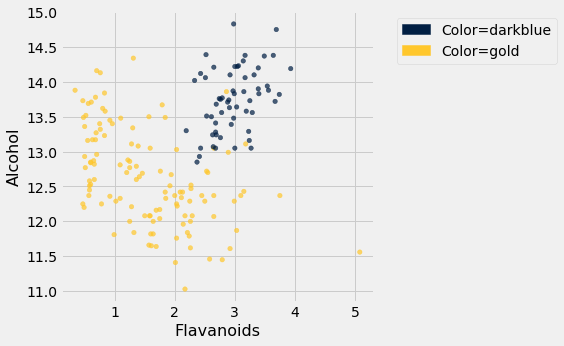

In [ ]:
wine_with_colors.scatter('Flavanoids', 'Alcohol', group='Color')

The blue points (Class 1) are almost entirely separate from the gold ones. That is one indication of why the distance between two Class 1 wines would be smaller than the distance between wines of two different classes. We can see a similar phenomenon with a different pair of attributes too:

But for some pairs the picture is more murky.

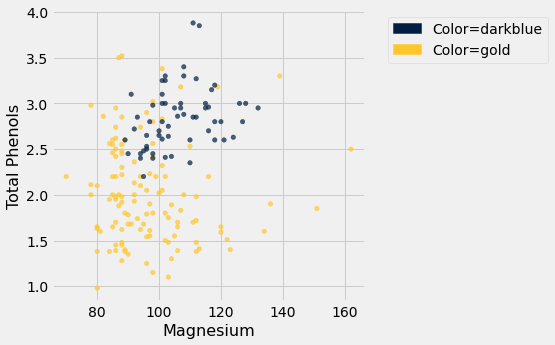

In [ ]:
wine_with_colors.scatter('Magnesium', 'Total Phenols', group='Color')

Let's see if we can implement a classifier based on all of the attributes. After that, we'll see how accurate it is.

###17.4.4. A Plan for the Implementation
It's time to write some code to implement the classifier.  The input is a `point` that we want to classify.  The classifier works by finding the $k$ nearest neighbors of `point` from the training set.  So, our approach will go like this:

1. Find the closest $k$ neighbors of `point`, i.e., the $k$ wines from the training set that are most similar to `point`.

2. Look at the classes of those $k$ neighbors, and take the majority vote to find the most-common class of wine.  Use that as our predicted class for `point`.

So that will guide the structure of our Python code.

In [ ]:
def closest(training, p, k):
    ...

def majority(topkclasses):
    ...

def classify(training, p, k):
    kclosest = closest(training, p, k)
    kclosest.classes = kclosest.select('Class')
    return majority(kclosest)

###17.4.5. Implementation Step 1
To implement the first step for the kidney disease data, we had to compute the distance from each patient in the training set to `point`, sort them by distance, and take the $k$ closest patients in the training set.  

That's what we did in the previous section with the point corresponding to Alice. Let's generalize that code. We'll redefine `distance` here, just for convenience.

In [ ]:
def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, new_point):
    """Returns an array of distances
    between each point in the training set
    and the new point (which is a row of attributes)"""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(np.array(new_point), np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, new_point):
    """Augments the training table 
    with a column of distances from new_point"""
    return training.with_column('Distance', all_distances(training, new_point))

def closest(training, new_point, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

Let's see how this works on our `wine` data. We'll just take the first wine and find its five nearest neighbors among all the wines. Remember that since this wine is part of the dataset, it is its own nearest neighbor. So we should expect to see it at the top of the list, followed by four others.

First let's extract its attributes:

In [ ]:
special_wine = wine.drop('Class').row(0)

And now let's find its 5 nearest neighbors.

In [ ]:
closest(wine, special_wine, 5)

Class,Alcohol,Malic Acid,Ash,Alkalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diulted wines,Proline,Distance
1,14.23,1.71,2.43,15.6,127,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.74,1.67,2.25,16.4,118,2.6,2.9,0.21,1.62,5.85,0.92,3.2,1060,10.3928
1,14.21,4.04,2.44,18.9,111,2.85,2.65,0.3,1.25,5.24,0.87,3.33,1080,22.3407
1,14.1,2.02,2.4,18.8,103,2.75,2.92,0.32,2.38,6.2,1.07,2.75,1060,24.7602
1,14.38,3.59,2.28,16,102,3.25,3.17,0.27,2.19,4.9,1.04,3.44,1065,25.0947


Bingo! The first row is the nearest neighbor, which is itself – there's a 0 in the `Distance` column as expected. All five nearest neighbors are of Class 1, which is consistent with our earlier observation that Class 1 wines appear to be clumped together in some dimensions.

###17.4.6. Implementation Steps 2 and 3
Next we need to take a "majority vote" of the nearest neighbors and assign our point the same class as the majority.

In [ ]:
def majority(topkclasses):
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, new_point, k):
    closestk = closest(training, new_point, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

In [ ]:
classify(wine, special_wine, 5)

1

If we change `special_wine` to be the last one in the dataset, is our classifier able to tell that it's in Class 0?

In [ ]:
special_wine = wine.drop('Class').row(177)
classify(wine, special_wine, 5)

0

Yes! The classifier gets this one right too.

But we don't yet know how it does with all the other wines, and in any case we know that testing on wines that are already part of the training set might be over-optimistic. In the final section of this chapter, we will separate the wines into a training and test set and then measure the accuracy of our classifier on the test set. 

##17.5. The Accuracy of the Classifier
To see how well our classifier does, we might put 50% of the data into the training set and the other 50% into the test set.  Basically, we are setting aside some data for later use, so we can use it to measure the accuracy of our classifier.  We've been calling that the *test set*. Sometimes people will call the data that you set aside for testing a *hold-out set*, and they'll call this strategy for estimating accuracy the *hold-out method*.

Note that this approach requires great discipline.  Before you start applying machine learning methods, you have to take some of your data and set it aside for testing.  You must avoid using the test set for developing your classifier: you shouldn't use it to help train your classifier or tweak its settings or for brainstorming ways to improve your classifier.  Instead, you should use it only once, at the very end, after you've finalized your classifier, when you want an unbiased estimate of its accuracy.

In [ ]:
def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, new_point):
    """Returns an array of distances
    between each point in the training set
    and the new point (which is a row of attributes)"""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(np.array(new_point), np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, new_point):
    """Augments the training table 
    with a column of distances from new_point"""
    return training.with_column('Distance', all_distances(training, new_point))

def closest(training, new_point, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, new_point, k):
    closestk = closest(training, new_point, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

In [ ]:
wine = Table.read_table(path_data + 'wine.csv')

# For converting Class to binary

def is_one(x):
    if x == 1:
        return 1
    else:
        return 0
    
wine = wine.with_column('Class', wine.apply(is_one, 0))

###17.5.1. Measuring the Accuracy of Our Wine Classifier
OK, so let's apply the hold-out method to evaluate the effectiveness of the $k$-nearest neighbor classifier for identifying wines.  The data set has 178 wines, so we'll randomly permute the data set and put 89 of them in the training set and the remaining 89 in the test set.

In [ ]:
wine

Class,Alcohol,Malic Acid,Ash,Alkalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diulted wines,Proline
1,14.23,1.71,2.43,15.6,127,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.2,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.4,1050
1,13.16,2.36,2.67,18.6,101,2.8,3.24,0.3,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.5,16.8,113,3.85,3.49,0.24,2.18,7.8,0.86,3.45,1480
1,13.24,2.59,2.87,21,118,2.8,2.69,0.39,1.82,4.32,1.04,2.93,735
1,14.2,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
1,14.39,1.87,2.45,14.6,96,2.5,2.52,0.3,1.98,5.25,1.02,3.58,1290
1,14.06,2.15,2.61,17.6,121,2.6,2.51,0.31,1.25,5.05,1.06,3.58,1295
1,14.83,1.64,2.17,14,97,2.8,2.98,0.29,1.98,5.2,1.08,2.85,1045
1,13.86,1.35,2.27,16,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


In [ ]:
shuffled_wine = wine.sample(with_replacement=False) 
training_set = shuffled_wine.take(np.arange(89))
test_set  = shuffled_wine.take(np.arange(89, 178))

We'll train the classifier using the 89 wines in the training set, and evaluate how well it performs on the test set. To make our lives easier, we'll write a function to evaluate a classifier on every wine in the test set:

In [ ]:
def count_zero(array):
    """Counts the number of 0's in an array"""
    return len(array) - np.count_nonzero(array)

def count_equal(array1, array2):
    """Takes two numerical arrays of equal length
    and counts the indices where the two are equal"""
    return count_zero(array1 - array2)

def evaluate_accuracy(training, test, k):
    test_attributes = test.drop('Class')
    def classify_testrow(row):
        return classify(training, row, k)
    c = test_attributes.apply(classify_testrow)
    return count_equal(c, test.column('Class')) / test.num_rows

Now for the grand reveal -- let's see how we did.  We'll arbitrarily use $k=5$.

In [ ]:
evaluate_accuracy(training_set, test_set, 5)

0.9213483146067416

The accuracy rate isn't bad at all for a simple classifier.

###17.5.2. Breast Cancer Diagnosis

Now I want to do an example based on diagnosing breast cancer.  I was inspired by Brittany Wenger, who won the Google national science fair in 2012 as a 17-year old high school student.  Here's Brittany:

![Brittany Wenger](http://i.huffpost.com/gen/701499/thumbs/o-GSF83-570.jpg?3)

Brittany's [science fair project](https://sites.google.com/a/googlesciencefair.com/science-fair-2012-project-64a91af142a459cfb486ed5cb05f803b2eb41354-1333130785-87/home) was to build a classification algorithm to diagnose breast cancer.  She won grand prize for building an algorithm whose accuracy was almost 99%. 

Let's see how well we can do, with the ideas we've learned in this course.

So, let me tell you a little bit about the data set.  Basically, if a woman has a lump in her breast, the doctors may want to take a biopsy to see if it is cancerous.  There are several different procedures for doing that.  Brittany focused on fine needle aspiration (FNA), because it is less invasive than the alternatives.  The doctor gets a sample of the mass, puts it under a microscope, takes a picture, and a trained lab tech analyzes the picture to determine whether it is cancer or not.  We get a picture like one of the following:

![benign](../../../images/benign.png)

![cancer](../../../images/malignant.png)

Unfortunately, distinguishing between benign vs malignant can be tricky.  So, researchers have studied the use of machine learning to help with this task.  The idea is that we'll ask the lab tech to analyze the image and compute various attributes: things like the typical size of a cell, how much variation there is among the cell sizes, and so on.  Then, we'll try to use this information to predict (classify) whether the sample is malignant or not.  We have a training set of past samples from women where the correct diagnosis is known, and we'll hope that our machine learning algorithm can use those to learn how to predict the diagnosis for future samples.

We end up with the following data set.  For the "Class" column, 1 means malignant (cancer); 0 means benign (not cancer).

In [ ]:
patients = Table.read_table(path_data + 'breast-cancer.csv').drop('ID')
patients

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0
8,10,10,8,7,10,9,7,1,1
1,1,1,1,2,10,3,1,1,0
2,1,2,1,2,1,3,1,1,0
2,1,1,1,2,1,1,1,5,0
4,2,1,1,2,1,2,1,1,0


So we have 9 different attributes.  I don't know how to make a 9-dimensional scatterplot of all of them, so I'm going to pick two and plot them:

In [ ]:
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
patients_with_colors = patients.join('Class', color_table)

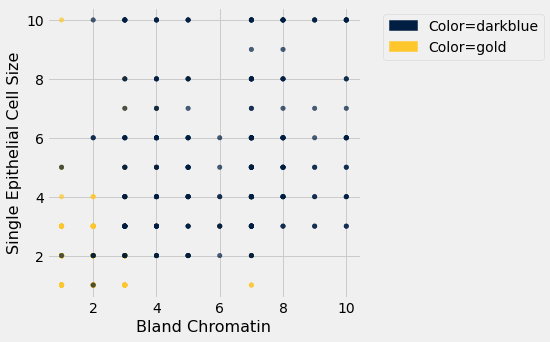

In [ ]:
patients_with_colors.scatter('Bland Chromatin', 'Single Epithelial Cell Size', group='Color')

Oops.  That plot is utterly misleading, because there are a bunch of points that have identical values for both the x- and y-coordinates.  To make it easier to see all the data points, I'm going to add a little bit of random jitter to the x- and y-values.  Here's how that looks:

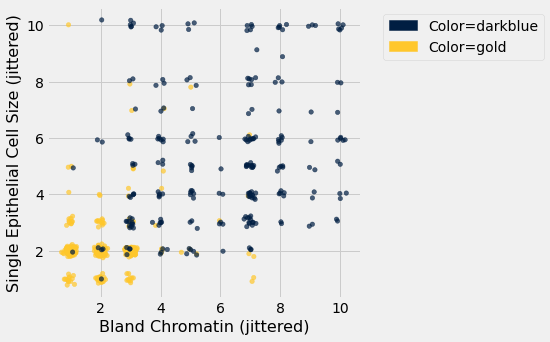

In [ ]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))
Table().with_columns(
        'Bland Chromatin (jittered)', 
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)', 
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Class', patients.column('Class')
    ).join('Class', color_table).scatter(1, 2, group='Color')

For instance, you can see there are lots of samples with chromatin = 2 and epithelial cell size = 2; all non-cancerous.

Keep in mind that the jittering is just for visualization purposes, to make it easier to get a feeling for the data.  We're ready to work with the data now, and we'll use the original (unjittered) data.

First we'll create a training set and a test set. The data set has 683 patients, so we'll randomly permute the data set and put 342 of them in the training set and the remaining 341 in the test set.

In [ ]:
shuffled_patients = patients.sample(683, with_replacement=False) 
training_set = shuffled_patients.take(np.arange(342))
test_set  = shuffled_patients.take(np.arange(342, 683))

Let's stick with 5 nearest neighbors, and see how well our classifier does.

In [ ]:
evaluate_accuracy(training_set, test_set, 5)

0.9648093841642229

Over 96% accuracy.  Not bad!  Once again, pretty darn good for such a simple technique.

As a footnote, you might have noticed that Brittany Wenger did even better.  What techniques did she use? One key innovation is that she incorporated a confidence score into her results: her algorithm had a way to determine when it was not able to make a confident prediction, and for those patients, it didn't even try to predict their diagnosis.  Her algorithm was 99% accurate on the patients where it made a prediction -- so that extension seemed to help quite a bit.

##17.6. Multiple Regression

In [ ]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

Now that we have explored ways to use multiple attributes to predict a categorical variable, let us return to predicting a quantitative variable. Predicting a numerical quantity is called regression, and a commonly used method to use multiple attributes for regression is called *multiple linear regression*.

###17.6.1. Home Prices

The following dataset of house prices and attributes was collected over several years for the city of Ames, Iowa. A [description of the dataset appears online](http://ww2.amstat.org/publications/jse/v19n3/decock.pdf). We will focus only a subset of the columns. We will try to predict the sale price column from the other columns.

In [ ]:
all_sales = Table.read_table(path_data + 'house.csv')
sales = all_sales.where('Bldg Type', '1Fam').where('Sale Condition', 'Normal').select(
    'SalePrice', '1st Flr SF', '2nd Flr SF', 
    'Total Bsmt SF', 'Garage Area', 
    'Wood Deck SF', 'Open Porch SF', 'Lot Area', 
    'Year Built', 'Yr Sold')
sales.sort('SalePrice')

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
35000,498,0,498,216,0,0,8088,1922,2006
39300,334,0,0,0,0,0,5000,1946,2007
40000,649,668,649,250,0,54,8500,1920,2008
45000,612,0,0,308,0,0,5925,1940,2009
52000,729,0,270,0,0,0,4130,1935,2008
52500,693,0,693,0,0,20,4118,1941,2006
55000,723,363,723,400,0,24,11340,1920,2008
55000,796,0,796,0,0,0,3636,1922,2008
57625,810,0,0,280,119,24,21780,1910,2009
58500,864,0,864,200,0,0,8212,1914,2010


A histogram of sale prices shows a large amount of variability and a distribution that is clearly not normal. A long tail to the right contains a few houses that had very high prices. The short left tail does not contain any houses that sold for less than $35,000.

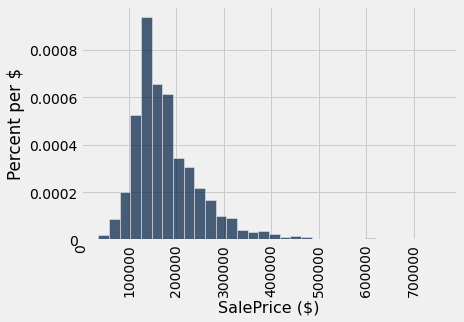

In [ ]:
sales.hist('SalePrice', bins=32, unit='$')

####17.6.1.1. Correlation

No single attribute is sufficient to predict the sale price. For example, the area of first floor, measured in square feet, correlates with sale price but only explains some of its variability.

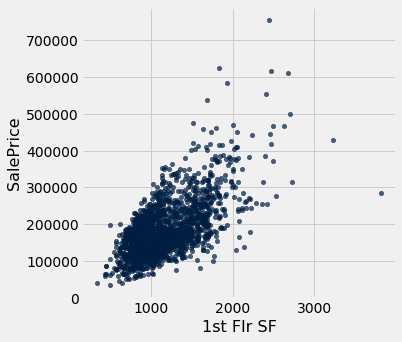

In [ ]:
sales.scatter('1st Flr SF', 'SalePrice')

In [ ]:
correlation(sales, 'SalePrice', '1st Flr SF')

0.6424662541030225

In fact, none of the individual attributes have a correlation with sale price that is above 0.7 (except for the sale price itself).

In [ ]:
for label in sales.labels:
    print('Correlation of', label, 'and SalePrice:\t', correlation(sales, label, 'SalePrice'))

Correlation of SalePrice and SalePrice:	 1.0
Correlation of 1st Flr SF and SalePrice:	 0.6424662541030225
Correlation of 2nd Flr SF and SalePrice:	 0.3575218942800824
Correlation of Total Bsmt SF and SalePrice:	 0.652978626757169
Correlation of Garage Area and SalePrice:	 0.6385944852520443
Correlation of Wood Deck SF and SalePrice:	 0.3526986661950492
Correlation of Open Porch SF and SalePrice:	 0.3369094170263733
Correlation of Lot Area and SalePrice:	 0.2908234551157694
Correlation of Year Built and SalePrice:	 0.5651647537135916
Correlation of Yr Sold and SalePrice:	 0.02594857908072111


However, combining attributes can provide higher correlation. In particular, if we sum the first floor and second floor areas, the result has a higher correlation than any single attribute alone.

In [ ]:
both_floors = sales.column(1) + sales.column(2)
correlation(sales.with_column('Both Floors', both_floors), 'SalePrice', 'Both Floors')

0.7821920556134877

This high correlation indicates that we should try to use more than one attribute to predict the sale price. In a dataset with multiple observed attributes and a single numerical value to be predicted (the sale price in this case), multiple linear regression can be an effective technique.

###17.6.2. Multiple Linear Regression 

In multiple linear regression, a numerical output is predicted from numerical input attributes by multiplying each attribute value by a different slope, then summing the results. In this example, the slope for the `1st Flr SF` would represent the dollars per square foot of area on the first floor of the house that should be used in our prediction. 

Before we begin prediction, we split our data randomly into a training and test set of equal size.

In [ ]:
train, test = sales.split(1001) #Spliting dataset into two randomly
print(train.num_rows, 'training and', test.num_rows, 'test instances.')

1001 training and 1001 test instances.


In [ ]:
test.row(0)

Row(SalePrice=98000, 1st Flr SF=1014, 2nd Flr SF=0, Total Bsmt SF=0.0, Garage Area=267.0, Wood Deck SF=0, Open Porch SF=0, Lot Area=7785, Year Built=1956, Yr Sold=2008)

The slopes in multiple regression is an array that has one slope value for each attribute in an example. Predicting the sale price involves multiplying each attribute by the slope and summing the result.

In [ ]:
def predict(slopes, row):
    return sum(slopes * np.array(row))

example_row = test.drop('SalePrice').row(0)
print('Predicting sale price for:', example_row)
example_slopes = np.random.normal(10, 1, len(example_row))
print('Using slopes:', example_slopes)
print('Result:', predict(example_slopes, example_row))

Predicting sale price for: Row(1st Flr SF=1014, 2nd Flr SF=0, Total Bsmt SF=0.0, Garage Area=267.0, Wood Deck SF=0, Open Porch SF=0, Lot Area=7785, Year Built=1956, Yr Sold=2008)
Using slopes: [10.12211546  9.41057722  7.819661    9.50930868  9.07860209  9.30164662
 10.14233368  7.33615969 13.24154057]
Result: 132699.42002812328


The result is an estimated sale price, which can be compared to the actual sale price to assess whether the slopes provide accurate predictions. Since the `example_slopes` above were chosen at random, we should not expect them to provide accurate predictions at all.

In [ ]:
print('Actual sale price:', test.column('SalePrice').item(0))
print('Predicted sale price using random slopes:', predict(example_slopes, example_row))

Actual sale price: 98000
Predicted sale price using random slopes: 132699.42002812328


####17.6.2.1. Least Squares Regression

The next step in performing multiple regression is to define the least squares objective. We perform the prediction for each row in the training set, and then compute the root mean squared error (RMSE) of the predictions from the actual prices.

In [ ]:
train_prices = train.column(0)
train_attributes = train.drop(0)

def rmse(slopes, attributes, prices):
    errors = []
    for i in np.arange(len(prices)):
        predicted = predict(slopes, attributes.row(i))
        actual = prices.item(i)
        errors.append((predicted - actual) ** 2)
    return np.mean(errors) ** 0.5

def rmse_train(slopes):
    return rmse(slopes, train_attributes, train_prices)

print('RMSE of all training examples using random slopes:', rmse_train(example_slopes))

RMSE of all training examples using random slopes: 91853.97410633999


Finally, we use the `minimize` function to find the slopes with the lowest RMSE. Since the function we want to minimize, `rmse_train`, takes an array instead of a number, we must pass the `array=True` argument to `minimize`. When this argument is used, `minimize` also requires an initial guess of the slopes so that it knows the dimension of the input array. Finally, to speed up optimization, we indicate that `rmse_train` is a smooth function using the `smooth=True` attribute. Computation of the best slopes may take several minutes.

In [ ]:
best_slopes = minimize(rmse_train, start=example_slopes, smooth=True, array=True)
print('The best slopes for the training set:')
Table(train_attributes.labels).with_row(list(best_slopes)).show()
print('RMSE of all training examples using the best slopes:', rmse_train(best_slopes))

The best slopes for the training set:


1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
80.8849,79.4453,49.1918,54.3546,37.2861,12.7214,0.760486,500.872,-505.17


RMSE of all training examples using the best slopes: 33337.86267619333


####17.6.2.2. Interpreting Multiple Regression 

Let's interpret these results. The best slopes give us a method for estimating the price of a house from its attributes. A square foot of area on the first floor is worth about \$75 (the first slope), while one on the second floor is worth about \$70 (the second slope). The final negative value describes the market: prices in later years were lower on average.

The RMSE of around \$30,000 means that our best linear prediction of the sale price based on all of the attributes is off by around \$30,000 on the training set, on average.  We find a similar error when predicting prices on the test set, which indicates that our prediction method will generalize to other samples from the same population.

In [ ]:
test_prices = test.column(0)
test_attributes = test.drop(0)

def rmse_test(slopes):
    return rmse(slopes, test_attributes, test_prices)

rmse_linear = rmse_test(best_slopes)
print('Test set RMSE for multiple linear regression:', rmse_linear)

Test set RMSE for multiple linear regression: 29060.607978313874


If the predictions were perfect, then a scatter plot of the predicted and actual values would be a straight line with slope 1. We see that most dots fall near that line, but there is some error in the predictions.

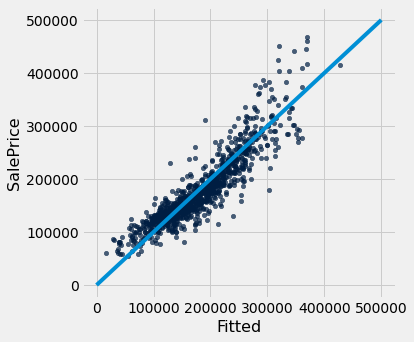

In [ ]:
def fit(row):
    return sum(best_slopes * np.array(row))

test.with_column('Fitted', test.drop(0).apply(fit)).scatter('Fitted', 0)
plots.plot([0, 5e5], [0, 5e5]);

A residual plot for multiple regression typically compares the errors (residuals) to the actual values of the predicted variable. We see in the residual plot below that we have systematically underestimated the value of expensive houses, shown by the many positive residual values on the right side of the graph.

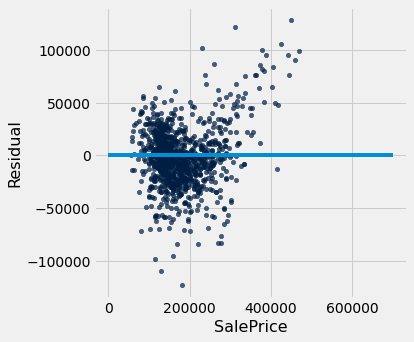

In [ ]:
test.with_column('Residual', test_prices-test.drop(0).apply(fit)).scatter(0, 'Residual')
plots.plot([0, 7e5], [0, 0]);

As with simple linear regression, interpreting the result of a predictor is at least as important as making predictions. There are many lessons about interpreting multiple regression that are not included in this textbook. A natural next step after completing this text would be to study linear modeling and regression in further depth.

###17.6.3. Nearest Neighbors for Regression

Another approach to predicting the sale price of a house is to use the price of similar houses. This *nearest neighbor* approach is very similar to our classifier. To speed up computation, we will only use the attributes that had the highest correlation with the sale price in our original analysis.

In [ ]:
train_nn = train.select(0, 1, 2, 3, 4, 8)
test_nn = test.select(0, 1, 2, 3, 4, 8)
train_nn.show(3)

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built
330000,1335,1203,1325,933,1996
45000,612,0,0,308,1940
207000,946,927,929,619,1988


The computation of closest neighbors is identical to a nearest-neighbor classifier. In this case, we will exclude the `'SalePrice'` rather than the `'Class'` column from the distance computation. The five nearest neighbors of the first test row are shown below.

In [ ]:
def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(row1), np.array(row2))

def distances(training, example, output):
    """Compute the distance from example for each row in training."""
    dists = []
    attributes = training.drop(output)
    for row in attributes.rows:
        dists.append(row_distance(row, example))
    return training.with_column('Distance', dists)

def closest(training, example, k, output):
    """Return a table of the k closest neighbors to example."""
    return distances(training, example, output).sort('Distance').take(np.arange(k))

example_nn_row = test_nn.drop(0).row(0)
closest(train_nn, example_nn_row, 5, 'SalePrice')

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built,Distance
104500,968,0,0,331,1956,78.8162
99000,925,0,0,300,1961,95.0526
97000,882,0,0,308,1956,138.221
109900,1040,0,0,420,1950,155.309
98300,1048,0,0,420,1950,156.847


One simple method for predicting the price is to average the prices of the nearest neighbors.

In [ ]:
def predict_nn(example):
    """Return the majority class among the k nearest neighbors."""
    return np.average(closest(train_nn, example, 5, 'SalePrice').column('SalePrice'))

predict_nn(example_nn_row)

101740.0

Finally, we can inspect whether our prediction is close to the true sale price for our one test example. Looks reasonable!

In [ ]:
print('Actual sale price:', test_nn.column('SalePrice').item(0))
print('Predicted sale price using nearest neighbors:', predict_nn(example_nn_row))

Actual sale price: 98000
Predicted sale price using nearest neighbors: 101740.0


####17.6.3.1. Evaluation

To evaluate the performance of this approach for the whole test set, we apply `predict_nn` to each test example, then compute the root mean squared error of the predictions. Computation of the predictions may take several minutes.

In [ ]:
nn_test_predictions = test_nn.drop('SalePrice').apply(predict_nn)
rmse_nn = np.mean((test_prices - nn_test_predictions) ** 2) ** 0.5

print('Test set RMSE for multiple linear regression: ', rmse_linear)
print('Test set RMSE for nearest neighbor regression:', rmse_nn)

Test set RMSE for multiple linear regression:  29060.607978313874
Test set RMSE for nearest neighbor regression: 31069.15977990539


For these data, the errors of the two techniques are quite similar! For different data sets, one technique might outperform another. By computing the RMSE of both techniques on the same data, we can compare methods fairly. One note of caution: the difference in performance might not be due to the technique at all; it might be due to the random variation due to sampling the training and test sets in the first place.

Finally, we can draw a residual plot for these predictions. We still underestimate the prices of the most expensive houses, but the bias does not appear to be as systematic. However, fewer residuals are very close to zero, indicating that fewer prices were predicted with very high accuracy. 

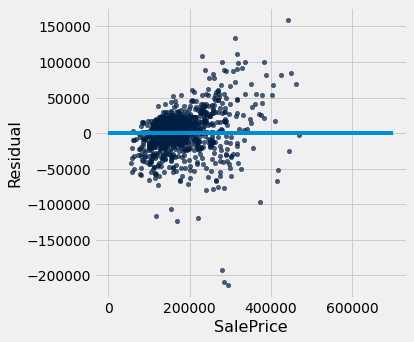

In [ ]:
test.with_column('Residual', test_prices-nn_test_predictions).scatter(0, 'Residual')
plots.plot([0, 7e5], [0, 0]);